# 3. Merchant Data Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
merchant = pd.read_csv('../data/curated/merchant/merchant_cleaned.csv')

## 3.1 Extract the tags 

In [4]:
# Create a new column with the first word of the goods
merchant['first_word'] = merchant['goods'].str.split().str[0]

# Define the mapping of values to replace
replace_dict = {
    'hobby': 'toy',
    'florist': 'housekeeping',
    'lawn': 'housekeeping',  # Added lawn to housekeeping mapping
    'digital': 'book',
    'watch': 'jewelry',
    'equipment': 'furniture',
    'cable': 'telecom',
    'artist': 'art',
    'health':'beauty',   
}

# Replace the values
merchant['first_word'] = merchant['first_word'].replace(replace_dict)


In [5]:
merchant["first_word"].value_counts()

computer        372
book            359
housekeeping    333
furniture       316
art             305
telecom         300
jewelry         261
shoe            185
gift            182
tent            178
bicycle         170
music           167
beauty          164
stationery      161
optician        151
motor           151
toy             142
antique         129
Name: first_word, dtype: int64

In [6]:
# write to csv
merchant.to_csv('../data/curated/merchant/merchant_cleaned2.csv', index=False)

visualization of tags distribution in merchant

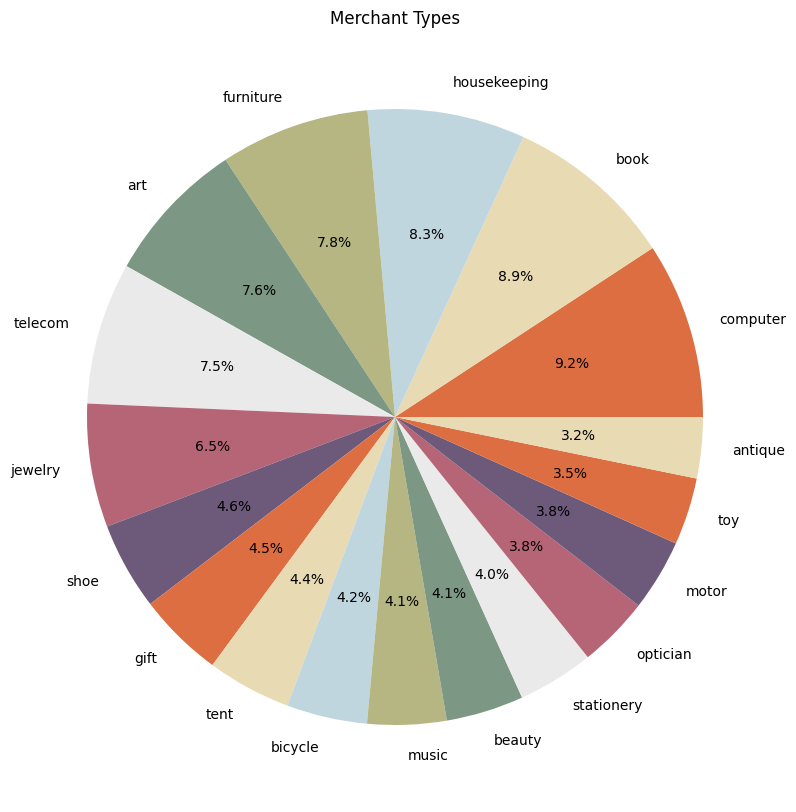

In [7]:
# draw a circle chart to see the distribution of the first word with percentage
merchant['first_word'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10), colors=['#dd6e42', '#e8dab2','#c0d6df','#b5b682', '#7c9885', '#eaeaea','#b56576','#6d597a'])
plt.title('Merchant Types')
plt.ylabel('')
plt.savefig('../plots/Merchant Types')
plt.show()

In [9]:
transaction = pd.read_parquet('../data/curated/transaction/transaction_merged.parquet')

## 3.2 Tags analysis 

### 3.2.1 Dollar value and tags 

In [10]:
# use the dollar_value in transaction to calculate the total amount of money by each first_word in merchant, match transaction with merchant by using merchant_abn
transaction = transaction.merge(merchant, left_on='merchant_abn', right_on='merchant_abn', how='left')
transaction['first_word'] = transaction['first_word'].dropna()
transaction['dollar_value'] = transaction['dollar_value'].astype(float)
transaction['first_word'] = transaction['first_word'].astype(str)

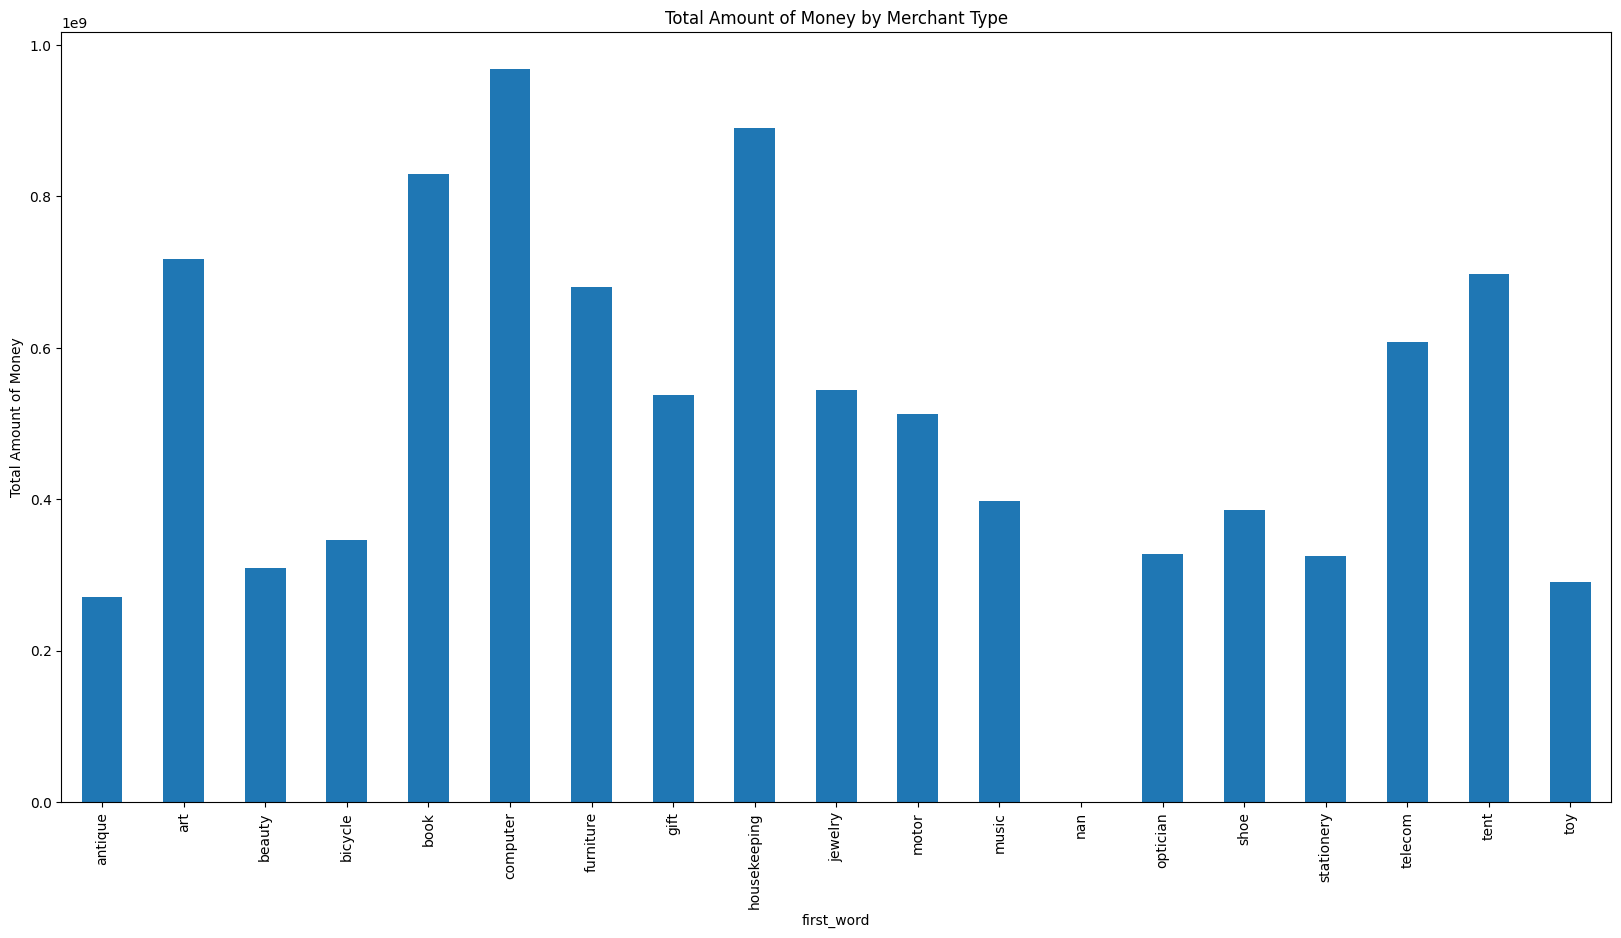

In [11]:
# plot the total amount of money by each first_word in merchant
plt.figure(figsize=(20, 10))
transaction["take_amount"] = transaction["dollar_value"] * transaction["take_rate"]
transaction.groupby('first_word')['take_amount'].sum().plot(kind='bar')
plt.title('Total Amount of Money by Merchant Type')
plt.ylabel('Total Amount of Money')
plt.show()

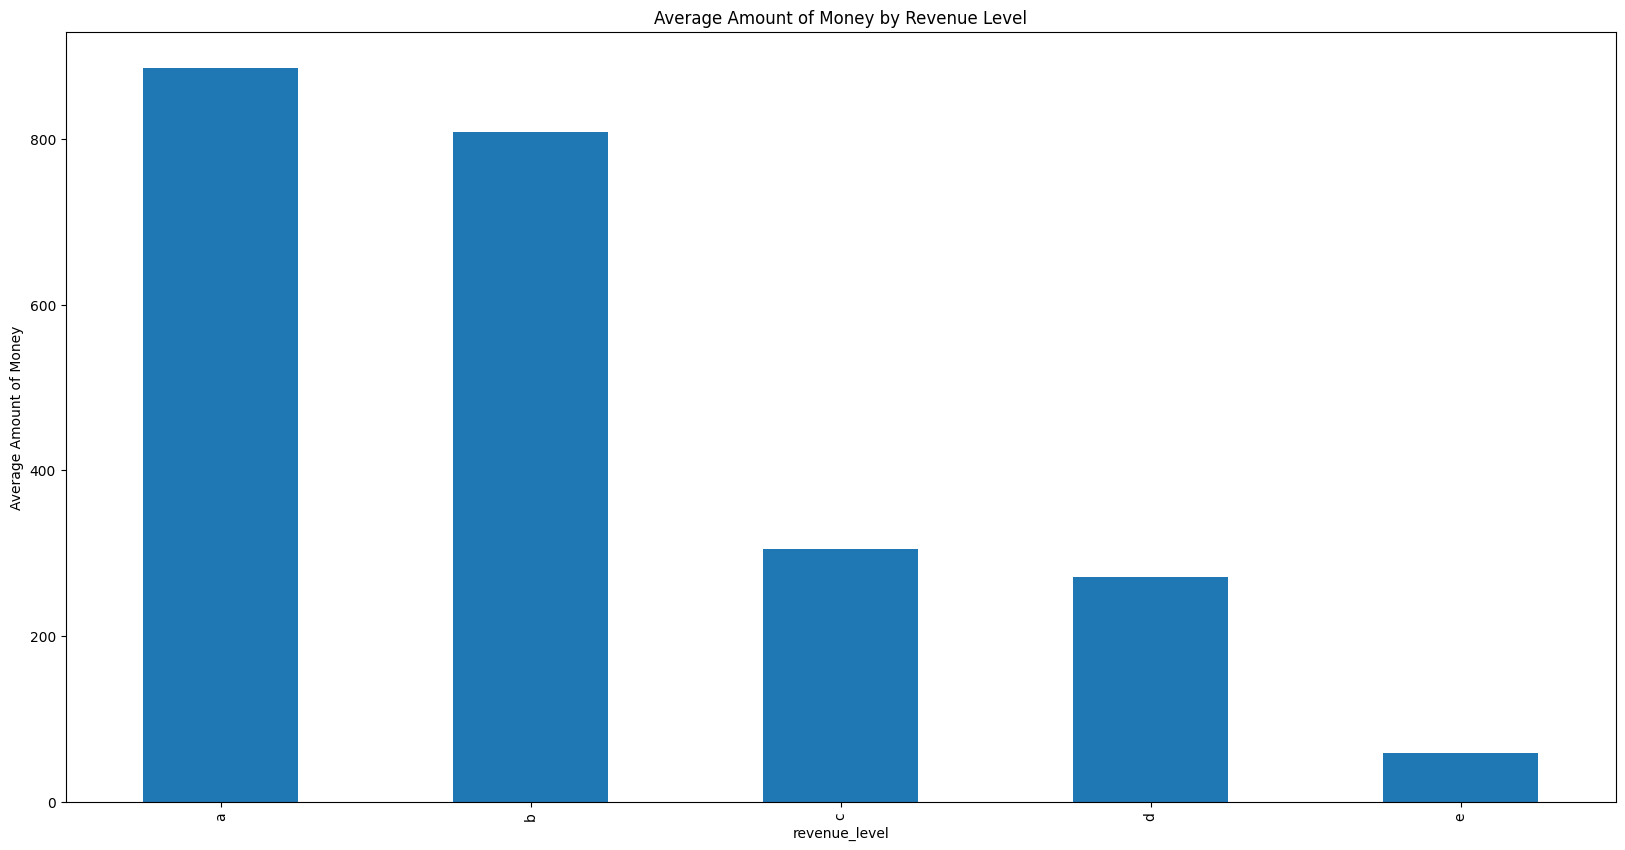

In [12]:
# plot the average amount of money by each revenue_level in merchant
plt.figure(figsize=(20, 10))
transaction.groupby('revenue_level')['take_amount'].mean().plot(kind='bar')
plt.title('Average Amount of Money by Revenue Level')
plt.ylabel('Average Amount of Money')
plt.show()

In [13]:
# get all the first_word under each revenue_level
revenue_level = transaction.groupby('revenue_level')['first_word'].unique()
revenue_level = pd.DataFrame(revenue_level)
revenue_level = revenue_level.reset_index()
revenue_level

,revenue_level,first_word
0,a,"[gift, housekeeping, tent, stationery, telecom..."
1,b,"[book, gift, jewelry, housekeeping, shoe, furn..."
2,c,"[furniture, art, book, telecom, tent, jewelry,..."
3,d,"[telecom, stationery, gift, antique, computer,..."
4,e,"[shoe, telecom, computer, jewelry, book, furni..."


# 3.3 Segment merchant by tags 

We decide to separate merchant by tags into 5 big segments, which is technical, lifestyle, entertainent, acceesory and specialty. 

In [14]:
# add a new column named 'segment' to merchant
technical = ['computer', 'telecom']
lifestyle = ['furniture', 'housekeeping', 'antique', 'art', 'stationery', 'gift', 'beauty']
entertainment = ['book', 'music', 'toy']
accessory = ['jewelry', 'shoe']
specialty = ['motor' ,'optician', 'bicycle', 'tent']

# create a new column called segment in merchant using the first_word
merchant['segment'] = merchant['first_word']
merchant['segment'] = merchant['segment'].replace(technical, 'technical')
merchant['segment'] = merchant['segment'].replace(lifestyle, 'lifestyle')
merchant['segment'] = merchant['segment'].replace(entertainment, 'entertainment')
merchant['segment'] = merchant['segment'].replace(accessory, 'accessory')
merchant['segment'] = merchant['segment'].replace(specialty, 'specialty')

merchant

,merchant_abn,name,goods,revenue_level,take_rate,first_word,segment
0,10023283211,Felis Limited,furniture home furnishing equipment shop manuf...,e,0.18,furniture,lifestyle
1,10142254217,Arcu Ac Orci Corporation,cable satellite pay television radio service,b,4.22,telecom,technical
2,10165489824,Nunc Sed Company,jewelry watch clock silverware shop,b,4.40,jewelry,accessory
3,10187291046,Ultricies Dignissim Lacus Foundation,watch clock jewelry repair shop,b,3.29,jewelry,accessory
4,10192359162,Enim Condimentum PC,music shop musical instrument piano sheet music,a,6.33,music,entertainment
...,...,...,...,...,...,...,...
4021,99938978285,Elit Dictum Eu Ltd,optician optical good eyeglass,b,4.50,optician,specialty
4022,99974311662,Mollis LLP,book periodical newspaper,b,3.17,book,entertainment
4023,99976658299,Sociosqu Corp.,shoe shop,a,6.57,shoe,accessory
4024,99987905597,Commodo Hendrerit LLC,motor vehicle supply new part,a,6.82,motor,specialty


In [15]:
# save merchant
merchant.to_csv('../data/curated/merchant/merchant_clean_segment.csv', index=False)

### 3.4 Visualized Feature Distribution 

Revenue Level Distribution 

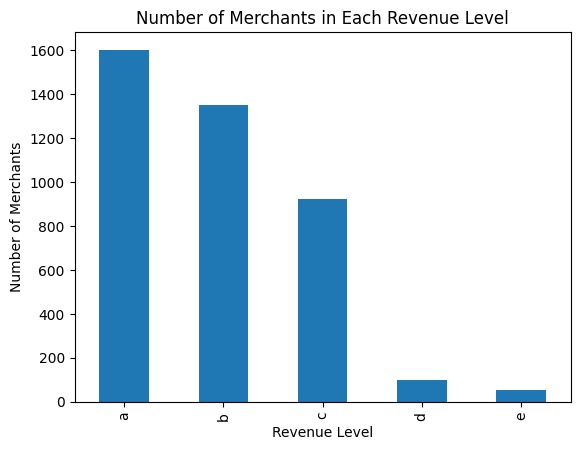

In [16]:
#draw a bar chart to show the number of merchants in each category
merchant['revenue_level'].value_counts().plot(kind='bar')
plt.xlabel('Revenue Level')
plt.ylabel('Number of Merchants')
plt.title('Number of Merchants in Each Revenue Level')
plt.savefig('../plots/Number of Merchants in Each Revenue Level')
plt.show()

Take Rate Distribution

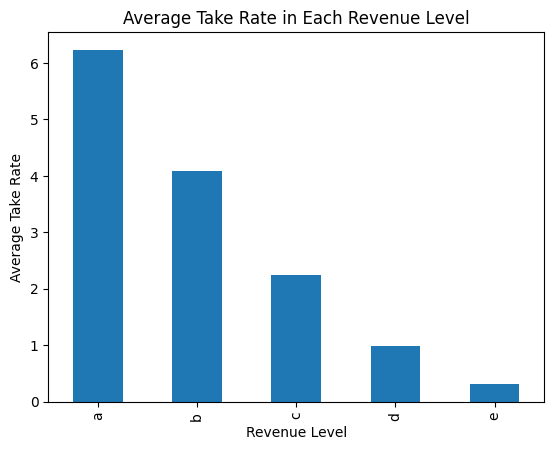

In [17]:
#find the avrage take_rate in each revenue level and Scatter Plot
merchant.groupby('revenue_level').take_rate.mean().plot(kind='bar', x='revenue_level', y='take_rate')
plt.xlabel('Revenue Level')
plt.ylabel('Average Take Rate')
plt.title('Average Take Rate in Each Revenue Level')
plt.savefig('../plots/Average Take Rate in Each Revenue Level')
plt.show()